In [1]:
using DynamicHMCModels

ProjDir = rel_path_d("..", "scripts", "12")

df = CSV.read(rel_path( "..", "data",  "Kline.csv"), delim=';');
size(df) # Should be 10x5

(10, 5)

New col logpop, set log() for population data

In [2]:
df[!, :logpop] = map((x) -> log(x), df[!, :population]);
df[!, :society] = 1:10;

first(df[!, [:total_tools, :logpop, :society]], 5)

struct m_12_06d_model{TY <: AbstractVector, TX <: AbstractMatrix,
  TS <: AbstractVector}
    "Observations (total_tools)."
    y::TY
    "Covariates (logpop)"
    X::TX
    "Society"
    S::TS
    "Number of observations (10)"
    N::Int
    "Number of societies (also 10)"
    N_societies::Int
end

Make the type callable with the parameters *as a single argument*.

In [3]:
function (problem::m_12_06d_model)(θ)
    @unpack y, X, S, N, N_societies = problem   # extract the data
    @unpack β, α, σ = θ  # β : a, bp, α : a_society
    ll = 0.0
    ll += logpdf(Cauchy(0, 1), σ)
    ll += sum(logpdf.(Normal(0, σ), α)) # α[1:10]
    ll += logpdf.(Normal(0, 10), β[1]) # a
    ll += logpdf.(Normal(0, 1), β[2]) # a
    ll += sum(
      [loglikelihood(Poisson(exp(α[S[i]] + dot(X[i, :], β))), [y[i]]) for i in 1:N]
    )
    ll
end

Instantiate the model with data and inits.

In [4]:
N = size(df, 1)
N_societies = length(unique(df[!, :society]))
X = hcat(ones(Int64, N), df[!, :logpop]);
S = df[!, :society]
y = df[!, :total_tools]
p = m_12_06d_model(y, X, S, N, N_societies);
θ = (β = [1.0, 0.25], α = rand(Normal(0, 1), N_societies), σ = 0.2)
p(θ)

-276.567892810621

Write a function to return properly dimensioned transformation.

In [5]:
problem_transformation(p::m_12_06d_model) =
    as( (β = as(Array, size(p.X, 2)), α = as(Array, p.N_societies), σ = asℝ₊) )

problem_transformation (generic function with 1 method)

Wrap the problem with a transformation, then use Flux for the gradient.

In [6]:
P = TransformedLogDensity(problem_transformation(p), p)
∇P = LogDensityRejectErrors(ADgradient(:ForwardDiff, P));
#∇P = ADgradient(:ForwardDiff, P);

Tune and sample.

In [7]:
posterior = Vector{Array{NamedTuple{(:β, :α, :σ),Tuple{Array{Float64,1},
  Array{Float64,1},Float64}},1}}(undef, 4)

for i in 1:4
  chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);
  posterior[i] = TransformVariables.transform.(Ref(problem_transformation(p)),
    get_position.(chain));
end

MCMC, adapting ϵ (75 steps)
0.0044 s/step ...done
MCMC, adapting ϵ (25 steps)
0.0045 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0035 s/step ...done
MCMC, adapting ϵ (100 steps)
0.0017 s/step ...done
MCMC, adapting ϵ (200 steps)
0.0011 s/step ...done
MCMC, adapting ϵ (400 steps)
0.00063 s/step ...done
MCMC, adapting ϵ (50 steps)
0.00063 s/step ...done
MCMC (1000 steps)
0.00048 s/step ...done
MCMC, adapting ϵ (75 steps)
0.0037 s/step ...done
MCMC, adapting ϵ (25 steps)
0.0054 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0042 s/step ...done
MCMC, adapting ϵ (100 steps)
0.0017 s/step ...done
MCMC, adapting ϵ (200 steps)
0.0011 s/step ...done
MCMC, adapting ϵ (400 steps)
0.00076 s/step ...done
MCMC, adapting ϵ (50 steps)
0.001 s/step ...done
MCMC (1000 steps)
0.00046 s/step ...done
MCMC, adapting ϵ (75 steps)
0.0044 s/step ...done
MCMC, adapting ϵ (25 steps)
0.0062 s/step ...done
MCMC, adapting ϵ (50 steps)
0.004 s/step ...done
MCMC, adapting ϵ (100 steps)
0.0016 s/step ...done
MCMC, adap

CmdStan result

In [8]:
m_12_6_result = "
Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
                            Mean                SD               Naive SE             MCSE            ESS
            a          1.076167468  0.7704872560 0.01218247319 0.0210530022 1000.000000
           bp         0.263056273  0.0823415805 0.00130193470 0.0022645077 1000.000000
  a_society.1   -0.191723568  0.2421382537 0.00382854195 0.0060563054 1000.000000
  a_society.2    0.054569029  0.2278506876 0.00360263570 0.0051693148 1000.000000
  a_society.3   -0.035935050  0.1926364647 0.00304584994 0.0039948433 1000.000000
  a_society.4    0.334355037  0.1929971201 0.00305155241 0.0063871707  913.029080
  a_society.5    0.049747513  0.1801287716 0.00284808595 0.0043631095 1000.000000
  a_society.6   -0.311903245  0.2096126337 0.00331426674 0.0053000536 1000.000000
  a_society.7    0.148637507  0.1744680594 0.00275858223 0.0047660246 1000.000000
  a_society.8   -0.164567976  0.1821341074 0.00287979309 0.0034297298 1000.000000
  a_society.9    0.277066965  0.1758237250 0.00278001719 0.0055844175  991.286501
 a_society.10   -0.094149204  0.2846206232 0.00450024719 0.0080735022 1000.000000
sigma_society    0.310352849  0.1374834682 0.00217380450 0.0057325226  575.187461
";

Set varable names

In [9]:
parameter_names = ["a", "bp", "sigma_society"]
pooled_parameter_names = ["a_society[$i]" for i in 1:10]

10-element Array{String,1}:
 "a_society[1]" 
 "a_society[2]" 
 "a_society[3]" 
 "a_society[4]" 
 "a_society[5]" 
 "a_society[6]" 
 "a_society[7]" 
 "a_society[8]" 
 "a_society[9]" 
 "a_society[10]"

Create a3d

In [10]:
a3d = Array{Float64, 3}(undef, 1000, 13, 4);
for j in 1:4
  for i in 1:1000
    a3d[i, 1:2, j] = values(posterior[j][i][1])
    a3d[i, 3, j] = values(posterior[j][i][3])
    a3d[i, 4:13, j] = values(posterior[j][i][2])
  end
end

chns = MCMCChains.Chains(a3d,
  vcat(parameter_names, pooled_parameter_names),
  Dict(
    :parameters => parameter_names,
    :pooled => pooled_parameter_names
  )
);

Describe the chain

In [11]:
describe(chns)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters    │ mean     │ std      │ naive_se   │ mcse       │
│     │ Symbol        │ Float64  │ Float64  │ Float64    │ Float64    │
├─────┼───────────────┼──────────┼──────────┼────────────┼────────────┤
│ 1   │ a             │ 1.11261  │ 0.732906 │ 0.0115883  │ 0.0148954  │
│ 2   │ bp            │ 0.259517 │ 0.079642 │ 0.00125925 │ 0.00158396 │
│ 3   │ sigma_society │ 0.306584 │ 0.131525 │ 0.0020796  │ 0.00328529 │

Quantiles

│ Row │ parameters    │ 2.5%      │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol        │ Float64   │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼───────────────┼───────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ a             │ -0.326316 │ 0.680205 │ 1.11906  │ 1.55972  │ 2.54311  │
│ 2   │ bp            │ 0.10101   │ 0.211419 │ 0.259439 │ 0.307213 │ 0.416956 │
│ 3   │ sigma_society │ 0.102872  │ 0.219048 │ 0.288308 │ 0.374036 │ 0

Describe the chain

In [12]:
describe(chns, sections=[:pooled])

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters    │ mean       │ std      │ naive_se   │ mcse       │
│     │ Symbol        │ Float64    │ Float64  │ Float64    │ Float64    │
├─────┼───────────────┼────────────┼──────────┼────────────┼────────────┤
│ 1   │ a_society[1]  │ -0.201615  │ 0.242927 │ 0.00384102 │ 0.00435096 │
│ 2   │ a_society[2]  │ 0.044925   │ 0.222861 │ 0.00352374 │ 0.00409331 │
│ 3   │ a_society[3]  │ -0.0401673 │ 0.187091 │ 0.00295816 │ 0.00288836 │
│ 4   │ a_society[4]  │ 0.326962   │ 0.193838 │ 0.00306485 │ 0.0038496  │
│ 5   │ a_society[5]  │ 0.0474655  │ 0.173878 │ 0.00274926 │ 0.00278115 │
│ 6   │ a_society[6]  │ -0.313271  │ 0.204578 │ 0.00323467 │ 0.00395335 │
│ 7   │ a_society[7]  │ 0.145395   │ 0.173501 │ 0.0027433  │ 0.00327534 │
│ 8   │ a_society[8]  │ -0.168432  │ 0.183545 │ 0.00290211 │ 0.00270457 │
│ 9   │ a_society[9]  │ 0.274347   │ 0.174657 │ 0.00276157 │ 0.00364489 │
│ 10  │ a_society[10] │ -0

Plot the chain parameters

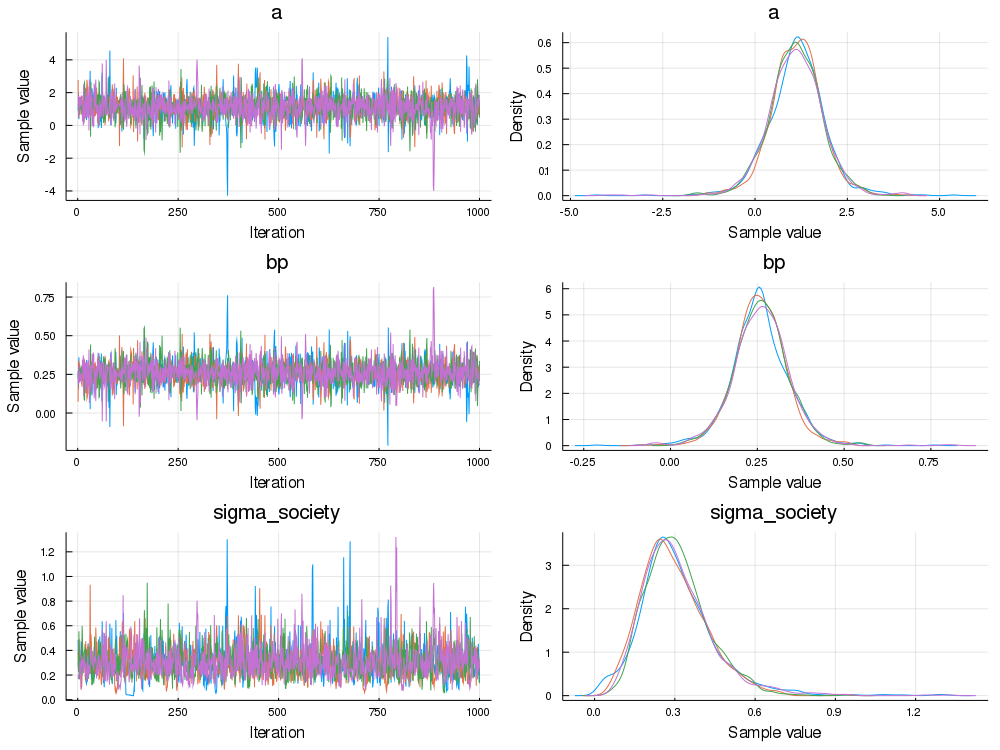

In [13]:
plot(chns)

Plot the chain pooled parameters

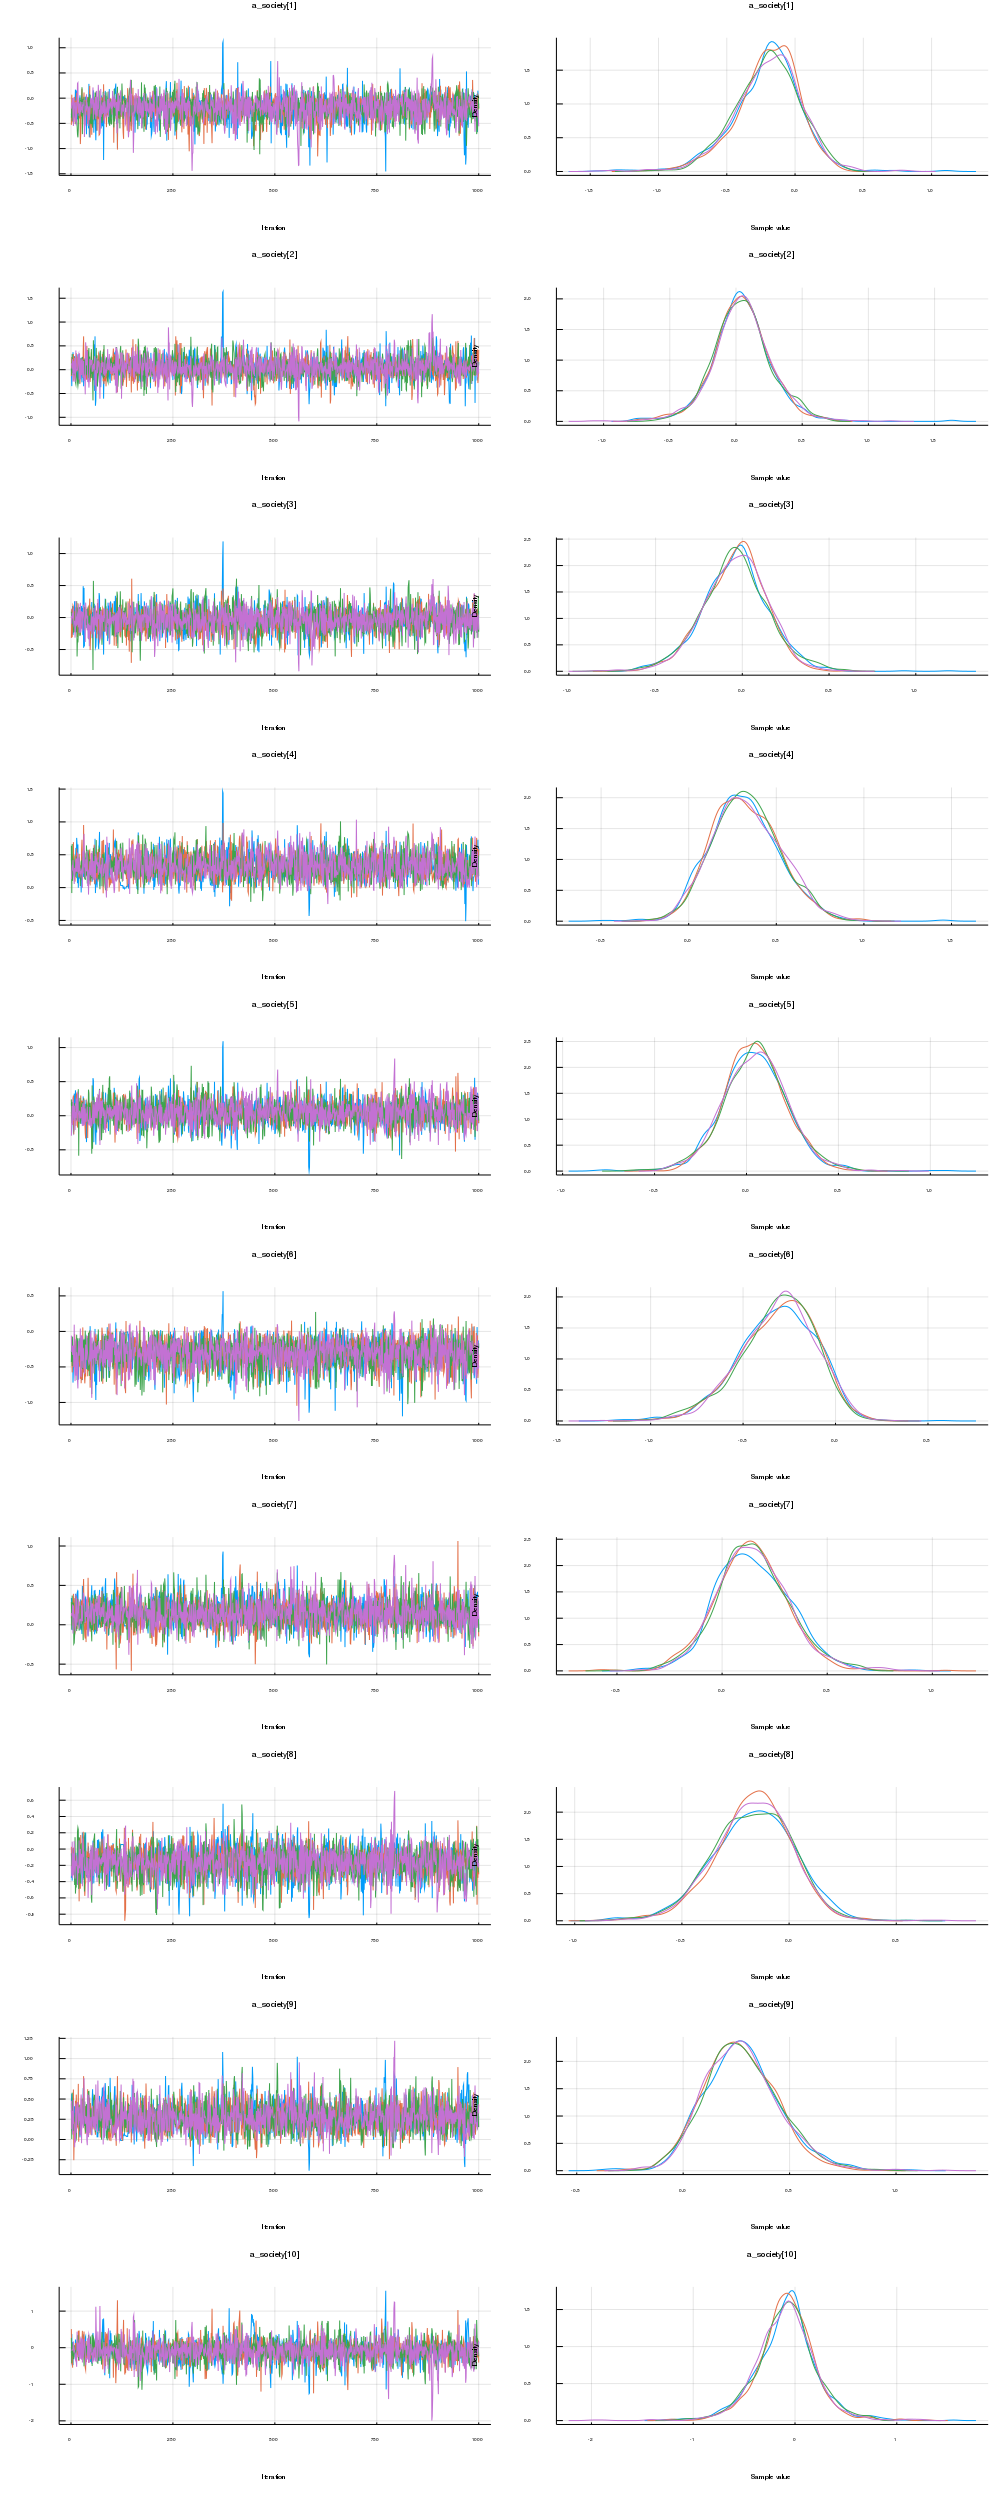

In [14]:
plot(chns, section=:pooled)

End of m12.6d.jl

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*